# 抽出された特徴量の評価

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import sklearn.preprocessing
%matplotlib inline


In [2]:
import glob

onomatpeia_list = [
    'clutter', 'gochagocha',
    'murmur', 'sarasara',
    'twinkle', 'kirakira',
]

dat = json.load(open("figure_features.json"))
dirname_list = []

for onomatpeia in onomatpeia_list:
    dirname_pattern = 'jsons/%s/*' % onomatpeia
    for dirname in sorted(glob.glob(dirname_pattern)):
        dirname_list.append(dirname)

shape_pool = np.load('shape_pool.npy')
shape_feat_pool = np.load('shape_feat_pool.npy')

In [3]:
for d, dirname in zip(dat, dirname_list):
    d = np.array(d)
    print dirname, "\t", d.mean(0)

jsons/clutter/JPN 	[ 0.36993459  0.04494595  0.01214311  0.00802554  0.00372029  0.00284782
  0.00112835  0.00094764  0.00104417  0.46486548  0.05358952  0.01300888
  0.00660356  0.00719529  0.00385711  0.00363533  0.00140909  0.00083989]
jsons/clutter/WRD 	[  3.85585548e-01   4.75371298e-02   1.03544297e-02   4.23022668e-03
   1.69542264e-03   1.92109093e-03   1.13620479e-03   4.18839022e-04
   6.81721004e-04   4.54935361e-01   6.02121161e-02   1.15217413e-02
   7.28805783e-03   4.04810599e-03   3.62032424e-03   2.43909420e-03
   1.46705592e-03   7.63328790e-04]
jsons/gochagocha/JPN 	[ 0.31519134  0.07322604  0.0292087   0.01246879  0.0058406   0.00378865
  0.00156889  0.00107925  0.00057434  0.40928321  0.0914223   0.02941768
  0.01273741  0.00639393  0.00435106  0.00207894  0.00078524  0.0004444 ]
jsons/gochagocha/WRD 	[  3.59979041e-01   3.62479660e-02   9.14820560e-03   4.51232923e-03
   2.25783827e-03   1.41483240e-03   7.17036751e-04   3.06951785e-04
   1.42612286e-04   5.095441

In [4]:
feat = np.array([np.array(d).mean(0) for d in dat])

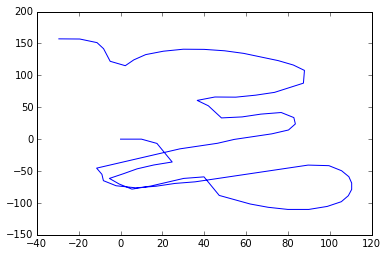

In [5]:
def gen_angle(idx):
    bin_range = 2 * np.pi / 18
    return np.random.random() * bin_range + bin_range * idx - np.pi


def randomwalk(feat, length):
    angle = []
    for i in range(length):
        idx = np.argmax(np.random.multinomial(1, feat))
        angle.append( gen_angle(idx) )
    angle = np.array(angle)
    
    path = gen_path(angle)
    
    return path

def gen_path(angle):
    point = np.zeros(2)
    path = [point.copy()]
    edge_len = 10
    direction = 0
    
    for a in angle:
        dp = np.array([np.cos(direction), np.sin(direction)]) * edge_len
        point += dp
        path.append(point.copy())
        direction += a

    path = np.vstack(path)

    return path


def poolwalk(feat, shape_pool, feat_pool, length):
    feat = np.array(feat)
    feat_pool = np.array(feat_pool)
    shape_pool = np.array(shape_pool)
    dist = np.linalg.norm(feat_pool - feat, axis=1)
    idx = np.argsort(dist)
    num = length / len(shape_pool[0])
    angle = np.hstack(shape_pool[idx][:num][np.random.permutation(num)])
    return gen_path(angle)
    

def plot_path(path, marker=None):
#     plt.subplot(111).set_aspect(1)

    plt.plot(*path.T, marker=marker)    

plot_path(poolwalk(feat[0], shape_pool[0], shape_feat_pool[0], 100))

In [6]:
def rotate(vec2, theta):
    mat = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]])
    return vec2.dot(mat)
    

In [7]:
def gen_circle(n, radius):
    xs = []
    for i in range(n):
        a = i * np.pi * 2 / n
        xs.append([np.cos(a), np.sin(a)])
    return np.array(xs) * radius

In [8]:
norm = lambda x: sklearn.preprocessing.normalize(x, norm='l1')[0]

def gen_bone(path, sigma):
    window_ = scipy.signal.gaussian(len(path) * 2, sigma)
    def window(x):
        l = len(window_)/2
        return norm(window_[l-x:2*l-x])[:, None]
    bone = np.array([(path * window(i)).sum(0) for i in range(len(path))])
    return bone


def to_circle(path, sigma):
    bone = gen_bone(path, sigma)
    bone_edge = bone[1:] - bone[:-1]
    
    meat = []

    for i in range(len(path)-1):
        p = path[i] - bone[i]
        e = bone_edge[i]
        arg = np.arctan2(p[1], p[0]) - np.arctan2(e[1], e[0])
        scale = np.linalg.norm(p) / np.linalg.norm(e)
        meat.append([arg, scale])
    
    circle = gen_circle(len(path), 200)
    circle_edge = circle[1:] - circle[:-1]
    
    circle_path = []
    for i in range(len(path)-1):
        arg, scale = meat[i]
        e = circle_edge[i]
        c = circle[i]
        p = c + rotate(e, arg) * scale
        circle_path.append(p)

    circle_path = np.array(circle_path)
    return circle_path


def gen_avarage_shape(feat, shape_pool, feat_pool, length, sigma=5):
    path = poolwalk(feat, shape_pool, feat_pool, length)
    return to_circle(path, sigma)
#     return path


# 平均図形の生成

In [9]:
sigma = 20
length = 100

In [10]:
num = 1

dirname = dirname_list[num]
print dirname

path = poolwalk(feat, shape_pool[num], shape_feat_pool[num], length)
plot_path(path)
plot_path(gen_bone(path, sigma=sigma))


jsons/clutter/WRD


ValueError: operands could not be broadcast together with shapes (357,18) (12,18) 

jsons/murmur/WRD


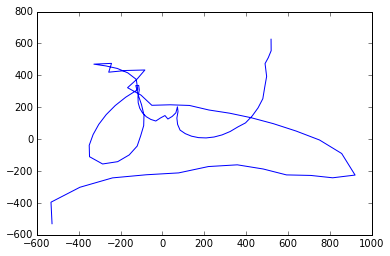

In [11]:
num = 5
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)

plot_path(gen_avarage_shape(feat, shape_pool[num], shape_feat_pool[num], length, sigma=sigma))

In [45]:
def plot_avarage_shape(num):
    dirname = dirname_list[num]
    feat = np.mean(dat[num], axis=0)
    path = gen_avarage_shape(feat, shape_pool[num], shape_feat_pool[num], length, sigma=sigma)
    plt.figure(figsize=(24, 8))
    plt.subplot(1, 4, num % 4 + 1).set_aspect(1)
    plt.plot(*path.T)
    plt.tight_layout()
    plt.title(dirname.replace('jsons/', ''))




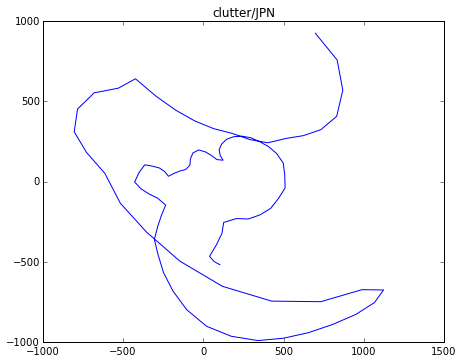

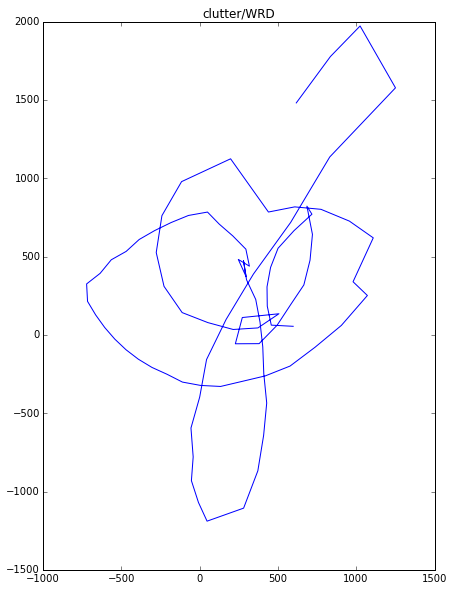

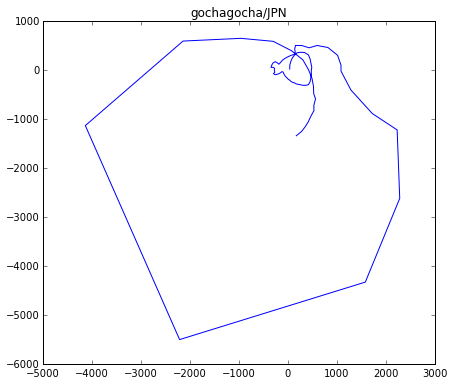

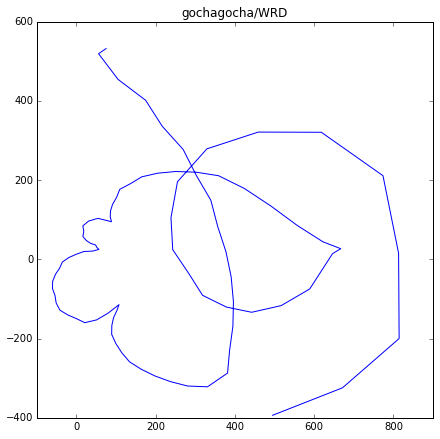

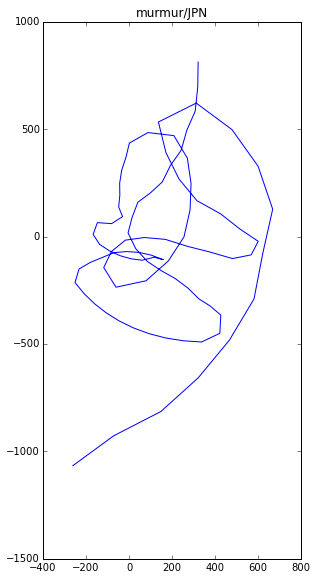

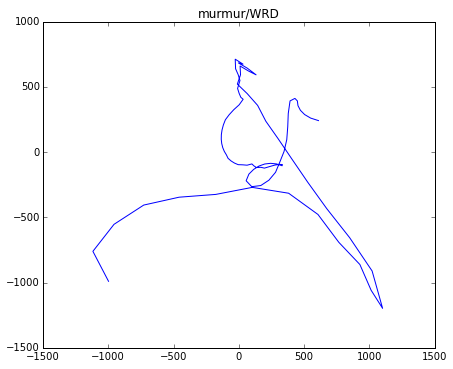

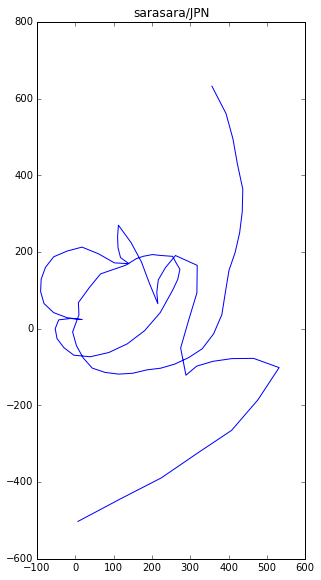

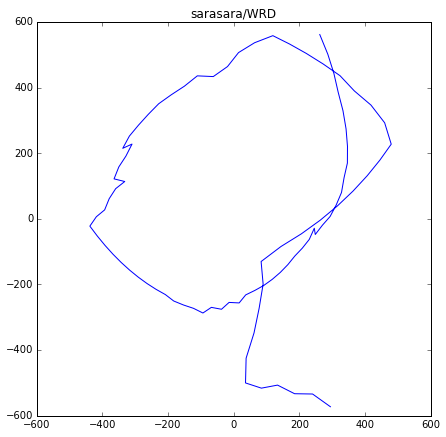

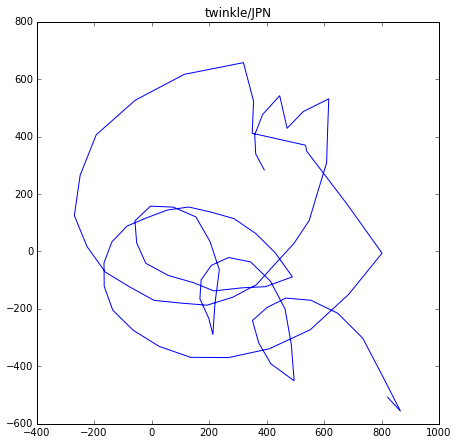

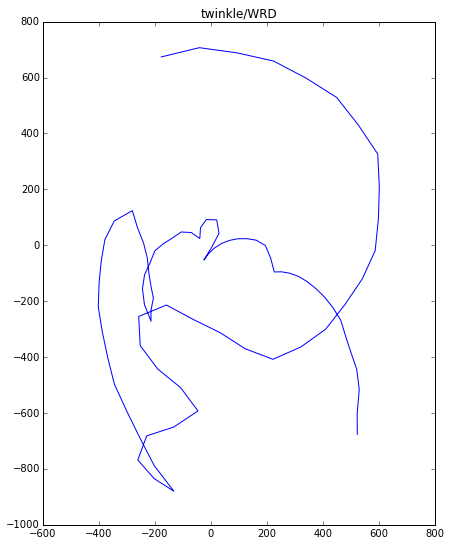

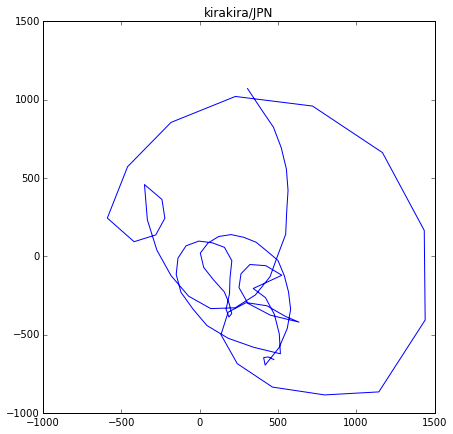

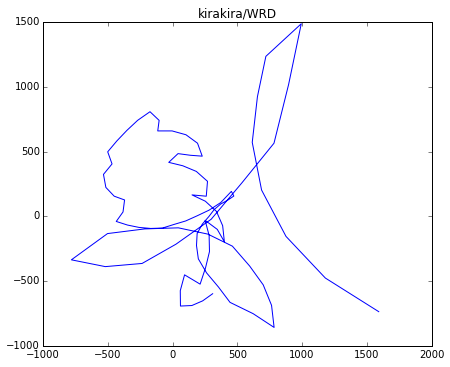

In [47]:
for num in range(0, 12):
    plot_avarage_shape(num)
plt.savefig('avarage_images/avarage-onomatopeia.pdf', format='pdf')

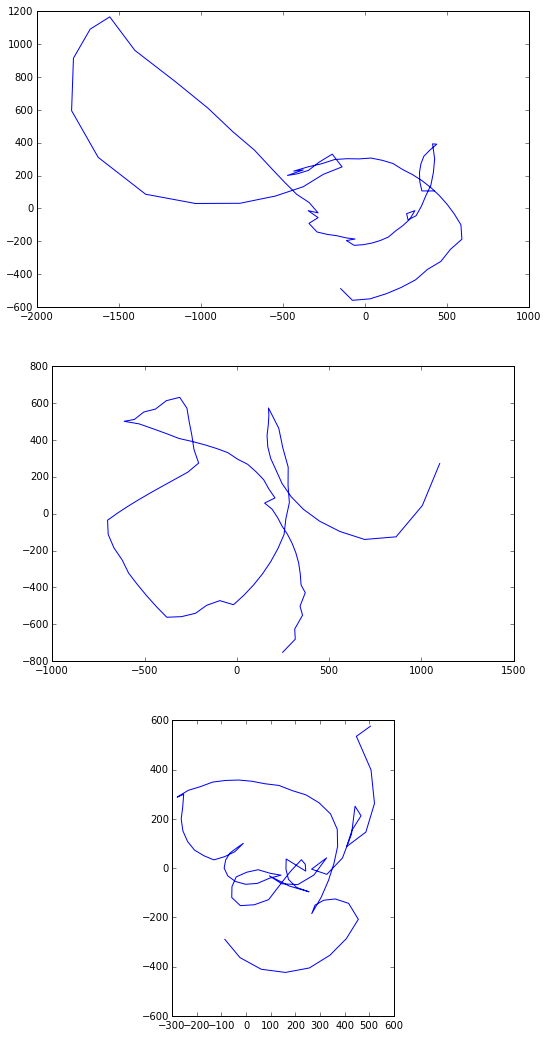

In [57]:
plt.figure(figsize=(12, 18))

for num in range(0, len(dirname_list), 4):
    feat = np.mean(np.vstack(dat[num:num+4]), axis=0)
    shape = gen_avarage_shape(feat, np.vstack(shape_pool[num:num+4]), np.vstack(shape_feat_pool[num:num+4]), length, sigma=sigma)
    plt.subplot(3, 1, num/4+1).set_aspect(1)
    plt.plot(*shape.T)
    dirname = '__'.join(dirname_list[num:num+4])
    
plt.savefig('avarage_images/genshou-avarage.pdf', format='pdf')

